In [1]:
import os

from lxml import etree
import base64
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from urllib.parse import urljoin
import pymorphy2
import string
from collections import Counter

import numpy as np

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

BYWEB_PATH = os.path.join('data', 'byweb_for_course')
STOPWORDS_EN = os.path.join('data', 'stopwords', 'english')
STOPWORDS_RU = os.path.join('data', 'stopwords', 'russian')

In [2]:
class Document:
    def __init__(self, raw):
        self.raw = raw

In [3]:
def pipeline(docs, foo_list):
    for foo in foo_list:
        def generator(docs, foo):
            for doc in docs:
                yield foo(doc)
        docs = generator(docs, foo)
    return docs

def generate_raw_docs(db_path):
    for file_name in tqdm(os.listdir(db_path)):
        file_path = os.path.join(db_path, file_name)
        root = etree.parse(file_path).getroot()
        for raw in root.getchildren():
            yield Document(raw)

In [4]:
def decoded_doc(doc):
    doc.html, doc.url, doc.doc_id = \
        list(map(lambda x: x.text, doc.raw))
    doc.url = base64.urlsafe_b64decode(doc.url).decode('cp1251')
    doc.html = base64.b64decode(doc.html).decode('cp1251')
    return doc

In [5]:
def build_text(doc):
    soup = BeautifulSoup(doc.html, 'lxml')
    for script in soup(['script', 'style']):
        script.decompose()
    doc.text = soup.get_text()
    doc.text = re.sub('(<!--.*?-->)', '', doc.text, flags=re.DOTALL)
    return doc

In [6]:
def get_tokenize_foo():
    tokenizer = RegexpTokenizer(r'\w+')
    def tokenize(doc):
        doc.tokens = tokenizer.tokenize(doc.text)
        return doc
    return tokenize

In [7]:
def get_lemmatization_foo():
    analyzer = pymorphy2.MorphAnalyzer()
    def lemmatization(doc):
        doc.lemmed_tokens = list(map(lambda x: x.lower(), doc.tokens))
        doc.lemmed_tokens = list(map(lambda x: analyzer.parse(x)[0].normal_form, doc.lemmed_tokens))
        return doc
    return lemmatization

In [8]:
def find_links(doc):
    soup = BeautifulSoup(doc.html)
    for script in soup(["script", "style"]):
        script.decompose()
    
    doc.links = set()
    for link in soup.findAll('a'):
        link_url = link.get('href')
        if not link_url or link_url[0] == '#':
            continue
        try:
            link_url = urljoin(url, link_url)
            doc.links.add(link_url)
        except Exception:
            pass
        
    return doc

In [ ]:
docs = pipeline(generate_raw_docs(BYWEB_PATH),
                [decoded_doc, build_text, get_tokenize_foo(), get_lemmatization_foo(), find_links])

doc_count = 0
content_byte_lens = []
content_word_lens = []
text_html_ratios = []
collection_dict = Counter()
count_for_idf = Counter()

for doc in docs:
    doc_count += 1
    content_byte_lens.append(len(doc.text))
    content_word_lens.append(len(doc.tokens))
    text_html_ratios.append(len(doc.text) / len(doc.html))
    
    collection_dict.update(doc.lemmed_tokens)
    
    count_for_idf.update(list(set(doc.lemmed_tokens)))

In [44]:
print('Count of docs: {}'.format(doc_count))

Count of docs: 20000


Mean doc length in bytes: 6670.31


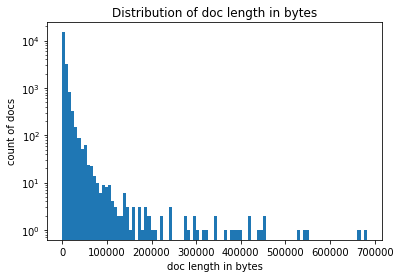

In [59]:
print('Mean doc length in bytes: {:.6}'.format(np.array(content_byte_lens).mean()))

plt.hist(content_byte_lens, bins=100)
plt.yscale('log')
plt.xlabel('doc length in bytes')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in bytes')
plt.show()

Mean doc length in bytes: 6670.31


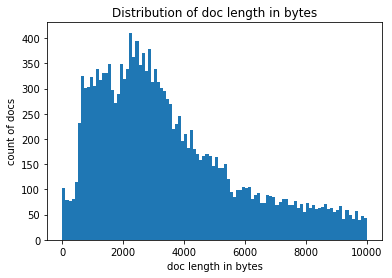

In [58]:
print('Mean doc length in bytes: {:.6}'.format(np.array(content_byte_lens).mean()))

plt.hist(content_byte_lens, bins=100, range=(0, 10000))
plt.xlabel('doc length in bytes')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in bytes')
plt.show()

Mean doc length in words: 863.78


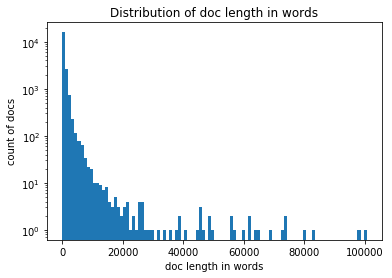

In [60]:
print('Mean doc length in words: {:.5}'.format(np.array(content_word_lens).mean()))

plt.hist(content_word_lens, bins=100)
plt.yscale('log')
plt.xlabel('doc length in words')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in words')
plt.show()

Mean doc length in words: 863.78


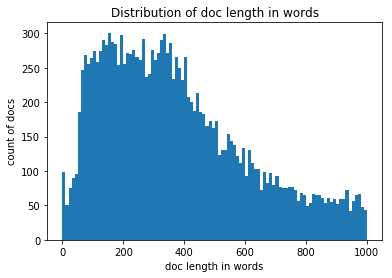

In [61]:
print('Mean doc length in words: {:.5}'.format(np.array(content_word_lens).mean()))

plt.hist(content_word_lens, bins=100, range=(0, 1000))
plt.xlabel('doc length in words')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in words')
plt.show()

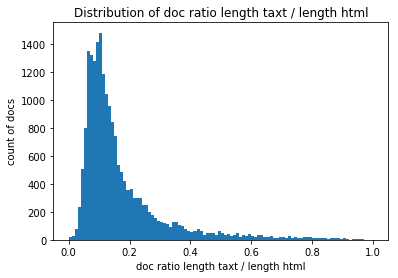

In [49]:
plt.hist(text_html_ratios, bins=100)
plt.xlabel('doc ratio length taxt / length html')
plt.ylabel('count of docs')
plt.title('Distribution of doc ratio length taxt / length html')
plt.show()

In [50]:
stopwords = set([line.rstrip('\n') for file_path in [STOPWORDS_EN, STOPWORDS_RU]
                                   for line in open(file_path)])

collection_word_cnt = sum(collection_dict[w] for w in collection_dict)
collection_stopword_cnt = sum(collection_dict[w] * int(w in stopwords) for w in collection_dict)

print('{} words of {} words in all collection are stop-words'.format(
    collection_stopword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_stopword_cnt / collection_word_cnt))

3055767 words of 17275692 words in all collection are stop-words
That is 17.69%


In [51]:
alphabet = set(list(string.ascii_lowercase))
def is_latin(word):
    return len(list(filter(lambda c: c not in alphabet, word))) == 0

collection_latinword_cnt = sum(collection_dict[w] * int(is_latin(w)) for w in collection_dict)

print('{} words of {} words in all collection are latin-words'.format(
    collection_latinword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_latinword_cnt / collection_word_cnt))

2943003 words of 17275692 words in all collection are latin-words
That is 17.04%


In [64]:
collection_word_sum_len = sum(len(w) * collection_dict[w] for w in collection_dict)
dict_word_sum_len = sum(len(w) for w in collection_dict)

print('Mean length of word in all collection is: {:.4}'.format(collection_word_sum_len / collection_word_cnt))
print('Mean length of word in dictionary is: {:.4}'.format(dict_word_sum_len / len(collection_dict)))

Mean length of word in all collection is: 5.467
Mean length of word in dictionary is: 9.15


In [54]:
top_words_by_cnt = filter(lambda x: x[0] not in stopwords, collection_dict.most_common())
top_words_by_cnt = filter(lambda x: not x[0].isdigit(), top_words_by_cnt)
top_words_by_cnt = list(top_words_by_cnt)[:20]

print('Most common words in collection without stop-words are:')
for word, cnt in top_words_by_cnt:
    print('Word "{}" occurs {} times'.format(word, cnt))

Most common words in collection without stop-words are:
Word "url" occurs 150457 times
Word "http" occurs 133556 times
Word "год" occurs 92587 times
Word "www" occurs 70606 times
Word "весь" occurs 68636 times
Word "это" occurs 54836 times
Word "р" occurs 53387 times
Word "org" occurs 50602 times
Word "сообщение" occurs 35696 times
Word "com" occurs 34175 times
Word "e" occurs 31997 times
Word "беларусь" occurs 31508 times
Word "который" occurs 31464 times
Word "мочь" occurs 31040 times
Word "работа" occurs 30042 times
Word "свой" occurs 28275 times
Word "новость" occurs 27629 times
Word "форум" occurs 27316 times
Word "html" occurs 26295 times
Word "buy" occurs 26066 times


In [55]:
idf = {word: np.log(doc_count / count_for_idf[word]) for word in count_for_idf}

top_words_by_idf = filter(lambda x: x not in stopwords, sorted(idf, key=idf.get))
top_words_by_idf = filter(lambda x: not x.isdigit(), top_words_by_idf)
top_words_by_idf = list(top_words_by_idf)[:20]

print('Words with largest idf are:')
for word in top_words_by_idf:
    print('Word "{}" has idf={:.4}'.format(word, idf[word]))

Words with largest idf are:
Word "весь" has idf=0.4205
Word "год" has idf=0.5497
Word "сайт" has idf=0.5821
Word "главный" has idf=0.7091
Word "новость" has idf=0.7531
Word "поиск" has idf=0.8098
Word "форум" has idf=0.85
Word "минск" has idf=0.8745
Word "работа" has idf=0.9054
Word "наш" has idf=0.9114
Word "беларусь" has idf=0.9168
Word "это" has idf=0.9188
Word "свой" has idf=0.9889
Word "регистрация" has idf=1.035
Word "мочь" has idf=1.085
Word "информация" has idf=1.121
Word "ваш" has idf=1.129
Word "каталог" has idf=1.147
Word "который" has idf=1.159
Word "страница" has idf=1.174


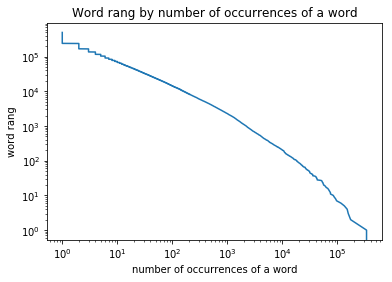

In [56]:
xs = [cnt for _, cnt in collection_dict.most_common()]
ys = list(range(len(collection_dict)))

plt.plot(xs, ys)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of occurrences of a word')
plt.ylabel('word rang')
plt.title('Word rang by number of occurrences of a word')
plt.show()